In [73]:
import math
import os
import cv2
import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.4.1', '1.19.5')

In [74]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "../input/face-recognition-dataset/Extracted Faces/Extracted Faces"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [75]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)
    
    random.shuffle(folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 1191
Length of testing list : 133

Test List: {'323': 2, '1': 2, '1479': 2, '1307': 4, '1588': 46, '1447': 4, '621': 7, '1074': 4, '649': 12, '1487': 4, '616': 13, '1045': 2, '1674': 2, '591': 11, '564': 2, '925': 2, '257': 3, '66': 3, '211': 4, '226': 7, '970': 2, '911': 3, '620': 4, '342': 2, '1531': 7, '1544': 2, '1486': 6, '389': 3, '460': 3, '435': 7, '155': 2, '858': 7, '1110': 3, '124': 2, '332': 2, '881': 3, '983': 2, '912': 3, '1184': 3, '586': 2, '985': 2, '959': 2, '803': 4, '1036': 2, '775': 2, '630': 2, '1506': 2, '707': 2, '1583': 2, '768': 3, '469': 4, '237': 3, '251': 7, '848': 2, '1527': 2, '1242': 2, '1256': 8, '418': 3, '1511': 2, '1002': 3, '532': 2, '268': 3, '741': 2, '824': 14, '234': 5, '197': 2, '1587': 3, '316': 4, '1370': 3, '184': 3, '205': 12, '940': 2, '492': 2, '625': 12, '294': 2, '1296': 2, '1147': 2, '361': 3, '311': 2, '631': 15, '32': 3, '1222': 2, '91': 3, '74': 7, '695': 3, '1189': 29, '1676': 9, '1677': 3, '876': 10, '747'

In [76]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                negative = (neg_folder, f"{neg_file}.jpg")

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets

In [77]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 9996
Number of testing triplets : 1235

Examples of triplets:
(('1308', '6.jpg'), ('1308', '7.jpg'), ('736', '0.jpg'))
(('422', '1.jpg'), ('422', '2.jpg'), ('1616', '12.jpg'))
(('1410', '3.jpg'), ('1410', '5.jpg'), ('1400', '1.jpg'))
(('1597', '3.jpg'), ('1597', '4.jpg'), ('495', '1.jpg'))
(('1580', '3.jpg'), ('1580', '4.jpg'), ('1072', '0.jpg'))


In [78]:
def get_batch(triplet_list, batch_size=256, preprocess=True):

    batch_steps = math.ceil(len(triplet_list)//batch_size)
    
    for i in range(batch_steps):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image(n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

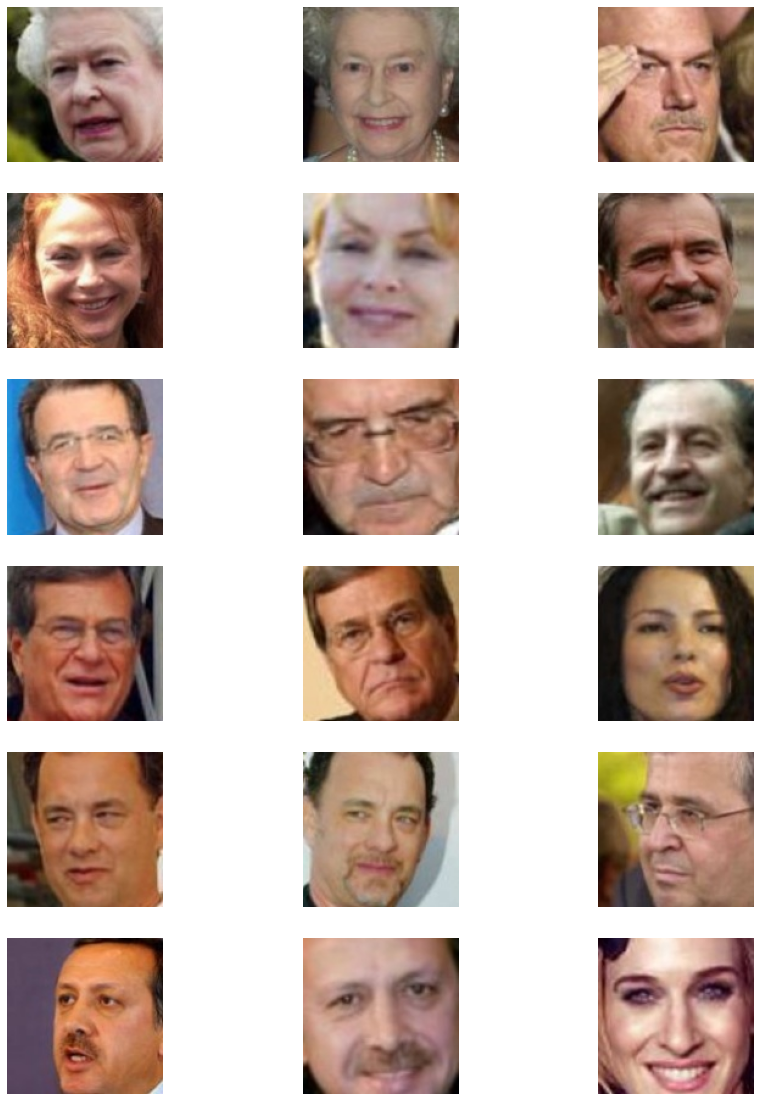

In [79]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for ax_row in axes:
    for ax in ax_row:
        ax.set_axis_off()  # Вимкнути показ осей на графіку

for x in get_batch(train_triplet, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

In [80]:
# from tensorflow.keras.applications.efficientnet  import EfficientNetB7, preprocess_input
# from tensorflow.keras.models import Sequential

# def get_encoder(input_shape):
#     x, y, ch = input_shape
#     """ Returns the image encoding model """

#     pretrained_model = EfficientNetB7(
#         input_shape=input_shape,
#         weights='imagenet',
#         include_top=False,
#         pooling=None  ##'avg',
#     )
#     for i in range(len(pretrained_model.layers)-19):
#         pretrained_model.layers[i].trainable = False
    

#     encode_model = Sequential([
#         #pretrained_model,
        
#         layers.Input(shape=input_shape),
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(128, (3, 3), activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(256, (3, 3), activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Flatten(),

#         #
#         layers.Dense(512, activation='relu'),
#         layers.BatchNormalization(),
#         layers.Dense(256, activation="relu"),
#         layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
#     ], name="Encode_Model")
#     return encode_model

In [81]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [82]:
def get_encoder(input_shape):
    x, y, ch = input_shape
    """ Returns the image encoding model """

    
    pretrained_model = Xception(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg',
    )
    
    for i in range(len(pretrained_model.layers)-27):
        pretrained_model.layers[i].trainable = False
    

    encode_model = Sequential([
        pretrained_model,
        
#         layers.Input(shape=input_shape),
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(128, (3, 3), activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Conv2D(256, (3, 3), activation='relu'),
#         layers.MaxPooling2D(),
#         layers.Flatten(),

        #
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

In [83]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          22043944    Anchor_Input[0][0]               
                                                                 Positive_Input[0][0

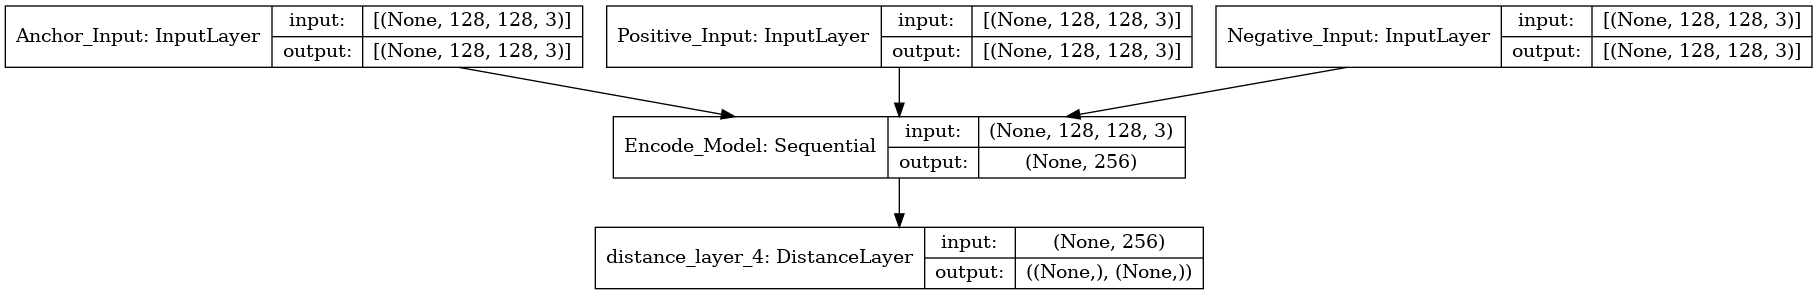

In [84]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [85]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [86]:
# from tensorflow.keras.applications import EfficientNetB5
# from tensorflow.keras.utils import plot_model


# model = EfficientNetB5(
#     input_shape=(224, 224, 3),  # або інша форма, яка підходить
#     weights='imagenet',
#     include_top=False,
#     pooling='avg'
# )

# plot_model(model, show_shapes=True, show_layer_names=True)

In [88]:
def test_on_triplets(test_triplets, batch_size = 256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplets, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    

    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [87]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

In [91]:
save_all = False
epochs = 10
batch_size = 256

max_acc = 0
train_loss = []
test_loss = []
test_metrics_arr = []
train_metrics_arr = []

In [92]:

t_start = time.time()
for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)
    epoch_loss_test = []
    
    for data in get_batch(test_triplet, batch_size=batch_size):
        loss = siamese_model.test_on_batch(data)
        epoch_loss_test.append(loss)
    epoch_loss_test = sum(epoch_loss_test)/len(epoch_loss_test)
    test_loss.append(epoch_loss_test)
    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on TRAIN    = {epoch_loss:.5f}")
    print(f"Loss on TEST    = {epoch_loss_test:.5f}")
    
    # Testing the model on test data
    metric_test = test_on_triplets(test_triplet, batch_size)
    metric_train = test_on_triplets(train_triplet, batch_size)
    test_metrics_arr.append(metric_test)
    train_metrics_arr.append(metric_train)
    
    accuracy_train = metric_train[0]
    print(f"Accuracy on TRAIN = {accuracy_train:.5f}")
    accuracy_test = metric_test[0]
    print(f"Accuracy on TEST = {accuracy_test:.5f}")
    
    # Saving the model weights
    if save_all or accuracy_test>=max_acc:
        siamese_model.save_weights(f"siamese_model_{epoch}")
        max_acc = accuracy_test
print(f"done in {int(time.time()-t_start)} sec")
# Saving the model after all epochs run
siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 96 sec)
Loss on TRAIN    = 0.34370
Loss on TEST    = 0.33758
Accuracy on TRAIN = 0.91486
Accuracy on TEST = 0.88477

EPOCH: 2 	 (Epoch done in 96 sec)
Loss on TRAIN    = 0.24785
Loss on TEST    = 0.32517
Accuracy on TRAIN = 0.95142
Accuracy on TEST = 0.89648

EPOCH: 3 	 (Epoch done in 95 sec)
Loss on TRAIN    = 0.18666
Loss on TEST    = 0.29971
Accuracy on TRAIN = 0.97326
Accuracy on TEST = 0.90820

EPOCH: 4 	 (Epoch done in 99 sec)
Loss on TRAIN    = 0.14440
Loss on TEST    = 0.27579
Accuracy on TRAIN = 0.98147
Accuracy on TEST = 0.91602

EPOCH: 5 	 (Epoch done in 95 sec)
Loss on TRAIN    = 0.11202
Loss on TEST    = 0.27425
Accuracy on TRAIN = 0.98768
Accuracy on TEST = 0.91504

EPOCH: 6 	 (Epoch done in 94 sec)
Loss on TRAIN    = 0.09059
Loss on TEST    = 0.29955
Accuracy on TRAIN = 0.99159
Accuracy on TEST = 0.91211

EPOCH: 7 	 (Epoch done in 98 sec)
Loss on TRAIN    = 0.07255
Loss on TEST    = 0.30041
Accuracy on TRAIN = 0.99269
Accuracy on TEST = 0.90234

KeyboardInterrupt: 

In [103]:
siamese_network = get_siamese_network()

new_siamese_model = SiameseModel(siamese_network)
new_siamese_model.load_weights("siamese_model-final")
# optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
# siamese_model.compile(optimizer=optimizer)

In [94]:
# new_siamese_model = siamese_model

Accuracy — загальна точність.

Precision / Recall.

FAR (False Acceptance Rate), FRR (False Rejection Rate).

ROC-AUC / PR AUC.

Confusion matrix.

Visualization: t-SNE / PCA для embeddings.

## **Evaluating the Model**


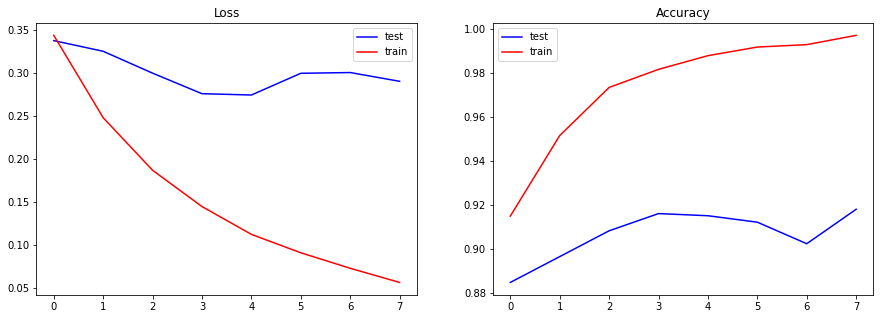

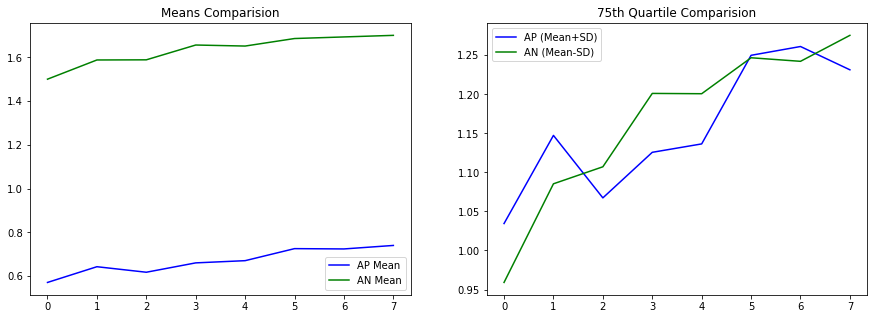

In [104]:
def plot_metrics(loss_train, loss_test, metrics_train, metrics_test):
    # Extracting individual metrics from metrics
    accuracy_train = metrics_train[:, 0]
    ap_mean_train  = metrics_train[:, 1]
    an_mean_train  = metrics_train[:, 2]
    ap_stds_train  = metrics_train[:, 3]
    an_stds_train  = metrics_train[:, 4]

    accuracy_test = metrics_test[:, 0]
    ap_mean_test  = metrics_test[:, 1]
    an_mean_test  = metrics_test[:, 2]
    ap_stds_test  = metrics_test[:, 3]
    an_stds_test  = metrics_test[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss_test, 'b', label='test')
    plt.plot(loss_train, 'r', label='train')
    plt.title('Loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy_test, 'b', label='test')
    plt.plot(accuracy_train, 'r', label='train')

    plt.title('Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean_test, 'b', label='AP Mean')
    plt.plot(an_mean_test, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean_test+ap_stds_test)
    an_75quartile = (an_mean_test-an_stds_test)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics_arr)
train_metrics = np.array(train_metrics_arr)
plot_metrics(train_loss, test_loss, train_metrics, test_metrics)

In [105]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(new_siamese_model)
encoder.save_weights("encoder")
encoder.summary()

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_20 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_54 (Batc (None, 512)               2048      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
lambda_10 (Lambda)           (None, 256)               0         
Total params: 22,043,944
Trainable params: 9,583,800
Non-trainable params: 12,460,144
_________________________________________________________________


In [106]:
def classify_images(face_list1, face_list2, threshold=1):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.798828125



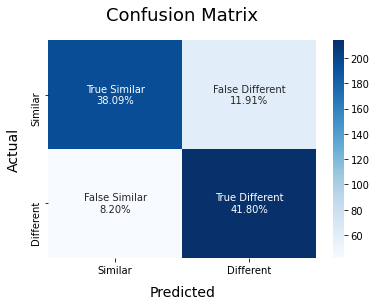

In [107]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Different', 'False Similar','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [112]:
def get_embeddings(model, triplets, batch_size=256):
    """
    Отримує ембеддінги для всіх унікальних зображень у triplets за допомогою моделі.
    """
    all_indexes = set()
    for a, p, n in triplets:
        all_indexes.update([a, p, n])
    all_indexes = list(all_indexes)

    all_embeddings = []
    for i in tqdm(range(0, len(all_indexes), batch_size), desc="Computing embeddings"):
        batch = [read_image(idx) for idx in all_indexes[i:i + batch_size]]
        batch = np.array(batch)
        batch = preprocess_input(batch)
        emb = model.predict(batch, verbose=0)
        all_embeddings.extend(emb)

    return {
        "embeddings": np.array(all_embeddings),
        "index": all_indexes
    }


In [100]:
def create_hard_triplets(embeddings, folder_list, max_files=10):
    """
    Створює складні триплети на основі ембеддінгів.
    - Hard positive = з того ж класу, але найдальший до анкора
    - Hard negative = з іншого класу, але найближчий до анкора
    """
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(ROOT, folder)
        files = list(os.listdir(path))[:max_files]
        file_keys = [(folder, f"{i}.jpg") for i in range(len(files))]

        # Позитивні приклади — ті самі люди
        for anchor_key in file_keys:
            anchor_emb = embeddings[anchor_key]

            # Hard positive: з того ж класу, найдальший
            hard_pos_key = max(
                (k for k in file_keys if k != anchor_key),
                key=lambda k: np.linalg.norm(anchor_emb - embeddings[k]),
                default=None
            )

            # Hard negative: з іншого класу, найближчий
            hard_neg_key = min(
                (k for k in embeddings.keys() if k[0] != folder),
                key=lambda k: np.linalg.norm(anchor_emb - embeddings[k]),
                default=None
            )

            if hard_pos_key and hard_neg_key:
                triplets.append((anchor_key, hard_pos_key, hard_neg_key))

    random.shuffle(triplets)
    return triplets


In [115]:
from tqdm import tqdm

In [116]:
def create_semi_hard_triplets_fast(model, directory, folder_list, embeddings, max_files=10, margin=1, negatives_per_pair=20):
    """
    Швидка генерація semi-hard triplet-ів.
    
    - negatives_per_pair: скільки випадкових негативних прикладів перевіряти для кожної пари anchor-positive.
    """
    triplets = []
    folders = list(folder_list.keys())
    
    # --- Збираємо всі ембеддінги в словник ---
    emb_dict = {}  # (folder, filename) -> embedding
    for (folder, fname), emb in zip(embeddings['index'], embeddings['embeddings']):
        emb_dict[(folder, fname)] = emb
    
    for folder in tqdm(folders, desc="Generating semi-hard triplets"):
        # Всі зображення цього класу
        filenames = [f"{i}.jpg" for i in range(min(folder_list[folder], max_files))]
        for i in range(len(filenames)):
            for j in range(i + 1, len(filenames)):
                anchor_key = (folder, filenames[i])
                positive_key = (folder, filenames[j])
                anchor_emb = emb_dict[anchor_key]
                positive_emb = emb_dict[positive_key]
                
                ap_dist = np.linalg.norm(anchor_emb - positive_emb)
                
                # --- Випадковий набір негативних класів ---
                other_folders = [f for f in folders if f != folder]
                neg_samples = []
                while len(neg_samples) < negatives_per_pair:
                    neg_folder = random.choice(other_folders)
                    num_files = min(folder_list[neg_folder], max_files)
                    if num_files == 0:
                        continue
                    neg_file = f"{random.randint(0, num_files - 1)}.jpg"
                    neg_key = (neg_folder, neg_file)
                    if neg_key in emb_dict:
                        neg_samples.append(neg_key)
                
                # --- Шукаємо semi-hard негатив ---
                for neg_key in neg_samples:
                    neg_emb = emb_dict[neg_key]
                    an_dist = np.linalg.norm(anchor_emb - neg_emb)
                    
                    if ap_dist < an_dist < ap_dist + margin:
                        triplets.append((anchor_key, positive_key, neg_key))
                        break  # знайшли один — йдемо далі

    random.shuffle(triplets)
    return triplets


In [125]:
MARGIN = 1

print("Generating embeddings...")
base_triplets = create_triplets(ROOT, train_list, max_files=10)
embeddings = get_embeddings(encoder, base_triplets, batch_size=batch_size)

print("Creating semi-hard triplets (fast)...")
train_triplet = create_semi_hard_triplets_fast(
    model=encoder,
    directory=ROOT,
    folder_list=train_list,
    embeddings=embeddings,
    max_files=10,
    margin=MARGIN,
    negatives_per_pair=25  # ← регулюй швидкість/якість
)


Generating embeddings...


Generating semi-hard triplets:   4%|▍         | 45/1191 [00:00<00:02, 434.50it/s]

Creating semi-hard triplets (fast)...


Generating semi-hard triplets: 100%|██████████| 1191/1191 [00:02<00:00, 397.31it/s]


In [122]:
print(len(train_triplet))

9276


In [126]:
save_all = False
epochs = 8
batch_size = 256

max_acc = 0
train_loss_new = []
test_loss_new = []
test_metrics_arr_new = []
train_metrics_arr_new = []

In [127]:
# import time

# t_start = time.time()
# # --- 1. Генеруємо triplets на основі поточних ембеддінгів ---
# print("Generating embeddings...")
# base_triplets = create_triplets(ROOT, train_list, max_files=5)
# embeddings = get_embeddings(encoder, base_triplets, batch_size=batch_size)

# print("Creating hard triplets...")
# train_triplet = create_semi_hard_triplets(    model=encoder,
#     directory=ROOT,
#     folder_list=train_list,
#     embeddings=embeddings, 
#     max_files=5)


In [ ]:
print(len(train_triplet))

In [ ]:
# train_triplet = train_triplet[:1000]

In [131]:
optimizer = Adam(learning_rate=1e-7, epsilon=1e-01)
new_siamese_model.compile(optimizer=optimizer)
for epoch in range(1, epochs+1):
    print(f"\nEpoch {epoch}/{epochs}")
    t = time.time()

    
    # --- 2. Тренування на нових hard triplets ---
    epoch_loss = []
    for data in get_batch(train_triplet, batch_size=batch_size):
        loss = new_siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss) / len(epoch_loss)
    train_loss_new.append(epoch_loss)
    
    # --- 3. Оцінка на test_triplet (звичайні, або теж можна зробити hard) ---
    epoch_loss_test = []
    for data in get_batch(test_triplet, batch_size=batch_size):
        loss = new_siamese_model.test_on_batch(data)
        epoch_loss_test.append(loss)
    epoch_loss_test = sum(epoch_loss_test) / len(epoch_loss_test)
    test_loss_new.append(epoch_loss_test)



    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on TRAIN    = {epoch_loss:.5f}")
    print(f"Loss on TEST    = {epoch_loss_test:.5f}")
    
    # Testing the model on test data
    metric_test = test_on_triplets(test_triplet, batch_size)
    metric_train = test_on_triplets(train_triplet, batch_size)
    test_metrics_arr_new.append(metric_test)
    train_metrics_arr_new.append(metric_train)
    
    accuracy_train = metric_train[0]
    print(f"Accuracy on TRAIN = {accuracy_train:.5f}")
    accuracy_test = metric_test[0]
    print(f"Accuracy on TEST = {accuracy_test:.5f}")
    
    # Saving the model weights
    if save_all or accuracy_test>=max_acc:
        # siamese_model.save_weights(f"siamese_model_{epoch}")
        max_acc = accuracy_test
        new_siamese_model.save_weights("new_siamese_model-final")
print(f"done in {int(time.time()-t_start)} sec")
# Saving the model after all epochs run


Epoch 1/8

EPOCH: 1 	 (Epoch done in 100 sec)
Loss on TRAIN    = 0.12369
Loss on TEST    = 0.41098
Accuracy on TRAIN = 0.93359
Accuracy on TEST = 0.91602

Epoch 2/8


KeyboardInterrupt: 

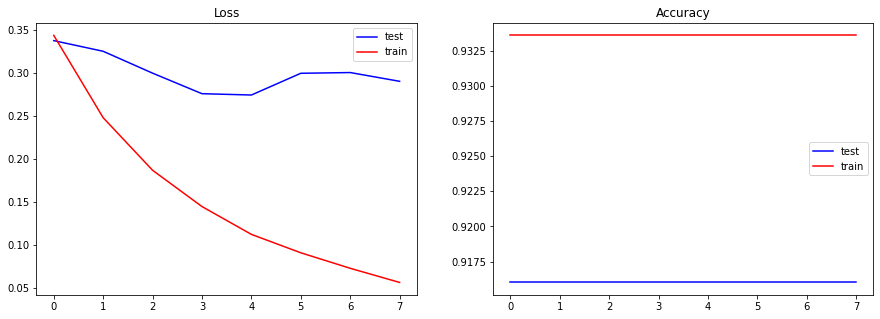

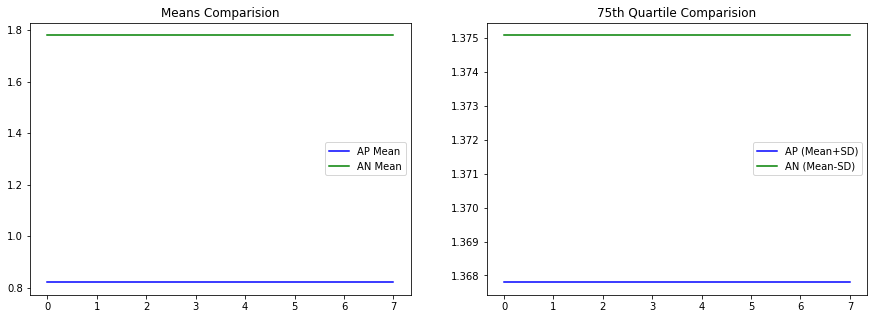

In [132]:
def plot_metrics(loss_train, loss_test, metrics_train, metrics_test):
    # Extracting individual metrics from metrics
    accuracy_train = metrics_train[:, 0]
    ap_mean_train  = metrics_train[:, 1]
    an_mean_train  = metrics_train[:, 2]
    ap_stds_train  = metrics_train[:, 3]
    an_stds_train  = metrics_train[:, 4]

    accuracy_test = metrics_test[:, 0]
    ap_mean_test  = metrics_test[:, 1]
    an_mean_test  = metrics_test[:, 2]
    ap_stds_test  = metrics_test[:, 3]
    an_stds_test  = metrics_test[:, 4]
    
    plt.figure(figsize=(15,5))
    
    # Plotting the loss over epochs
    plt.subplot(121)
    plt.plot(loss_test, 'b', label='test')
    plt.plot(loss_train, 'r', label='train')
    plt.title('Loss')
    plt.legend()
    
    # Plotting the accuracy over epochs
    plt.subplot(122)
    plt.plot(accuracy_test, 'b', label='test')
    plt.plot(accuracy_train, 'r', label='train')

    plt.title('Accuracy')
    plt.legend()
    
    plt.figure(figsize=(15,5))
    
    # Comparing the Means over epochs
    plt.subplot(121)
    plt.plot(ap_mean_test, 'b', label='AP Mean')
    plt.plot(an_mean_test, 'g', label='AN Mean')
    plt.title('Means Comparision')
    plt.legend()
    
    # Plotting the accuracy
    ap_75quartile = (ap_mean_test+ap_stds_test)
    an_75quartile = (an_mean_test-an_stds_test)
    plt.subplot(122)
    plt.plot(ap_75quartile, 'b', label='AP (Mean+SD)')
    plt.plot(an_75quartile, 'g', label='AN (Mean-SD)')
    plt.title('75th Quartile Comparision')
    plt.legend()

test_metrics = np.array(test_metrics_arr_new)
train_metrics = np.array(train_metrics_arr_new)
plot_metrics(train_loss, test_loss, train_metrics, test_metrics)

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense_32 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_84 (Batc (None, 512)               2048      
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
lambda_16 (Lambda)           (None, 256)               0         
Total params: 22,043,944
Trainable params: 9,583,800
Non-trainable params: 12,460,144
_________________________________________________________________

Accuracy of model: 0.79296875



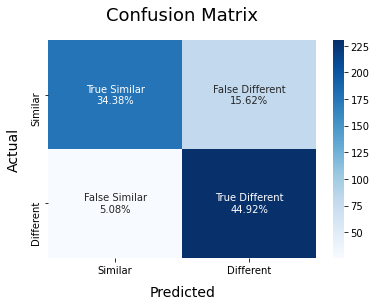

In [135]:
siamese_network = get_siamese_network()

new_siamese_model = SiameseModel(siamese_network)
new_siamese_model.load_weights("siamese_model-final")
# # optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
# # siamese_model.compile(optimizer=optimizer)

def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(new_siamese_model)
encoder.save_weights("encoder")
encoder.summary()

def classify_images(face_list1, face_list2, threshold=1.1):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Different', 'False Similar','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [ ]:

encoder_new = extract_encoder(siamese_model)

In [ ]:
def classify_images_new(face_list1, face_list2, threshold=0.0002):
    # Getting the encodings for the passed faces
    tensor1 = encoder_new.predict(face_list1)
    tensor2 = encoder_new.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction

In [ ]:


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images_new(a, p))
    neg_list = np.append(neg_list, classify_images_new(a, n))
    break

ModelMetrics(pos_list, neg_list)